In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from astropy.io import fits

%matplotlib notebook

Variables

In [73]:
outD = 7.77010  # primary diameter (m)
inD = 1.024  # inner M2 diameter (m)
m  = 8 # pad the array

## GPI DM parameters
N = 48          # number sample points across the screen 
                # (Not the number of subapertures across the aperture which is less)

nacross = 43.2    # number of subapertures across the aperture
    
## phase sample parameters
pscale = outD/(nacross)     #  pixel size (m) of samples in pupil plane

384
0.02248292824074074
0.1798634259259259


aperture

In [74]:
x         = np.linspace(-(pN)/2,(pN)/2,pN)*pscale 
y         = np.linspace(-(pN)/2,(pN)/2,pN)*pscale
ax,ay     = np.meshgrid(x,y)
ar        = np.sqrt(ax**2 +ay**2)  
ap_outer  = (ar <= outD/2)
ap_inner  = (ar <= inD/2)   
a        = (ap_outer ^ ap_inner)

In [ ]:
 if blackman:
        w  = np.blackman(48) 
        wx,wy = np.meshgrid(w,w)
        wr  = np.sqrt(wx**2 + wy**2) ## window radius
        

open the file

In [36]:
filename = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_5.53.56_poldm_phase.fits"

hdulist = fits.open(filename,memmap=True)
data = hdulist[0].data
    
# Get the phase dimensions
phdim = hdulist[0].data.shape 
phx   = phdim[1]
phy   = phdim[2]
timesteps = phdim[0]

Compute 2d fourier transform

In [64]:
phFT = np.zeros((timesteps,phx,phy), dtype=complex)
for t in np.arange(timesteps):
    phFT[t,:,:] = fft.fftshift(fft.fft2(data[t,:,:]*a))/(phx*phy)
print('Done with FT')

Done with FT


In [39]:
def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

Psd 

In [65]:
#mft = np.sum(phFT, axis=0)
   
psd2D = np.zeros((timesteps, phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
        
varpsd = np.sum(psd2D, axis=0)

1d psd plot

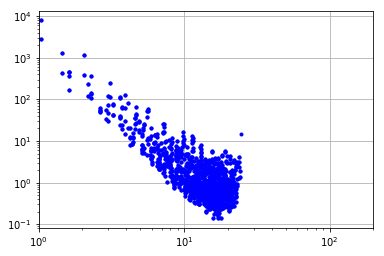

In [66]:
kx = fft.fftshift(fft.fftfreq(phx,pscale))
ky = fft.fftshift(fft.fftfreq(phx,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 
    
plt.figure(1)
plt.loglog(kr,varpsd,'b.')
plt.grid(True)
#plt.ylim(1e-8,1e2)
plt.xlim(1,200)
plt.show()